# Equity Options Portfolio Optimization:
**Authors:** William Lester, Luke Rutherford, Dylan Kynoch, Henry Daniel \
**Start Date:** 4/17/2024 \
**Last Updated:** 4/17/2024

In [61]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import data_functions as dat_func, visualizations as vis
from scipy.optimize import minimize
from scipy.linalg import cholesky
from scipy.stats import norm, poisson

In [62]:
start_date,end_date="2022-01-01","2023-01-01"
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)

tickers = ['XOM', 'WMT', 'GPC', 'OXY', 'PM', 'NNI', 'FI', 'ATKR', 'VICI', 'ADBE', 'AMAT', 'STLD']
ex_stock='GPC'

[*********************100%***********************]  12 of 12 completed


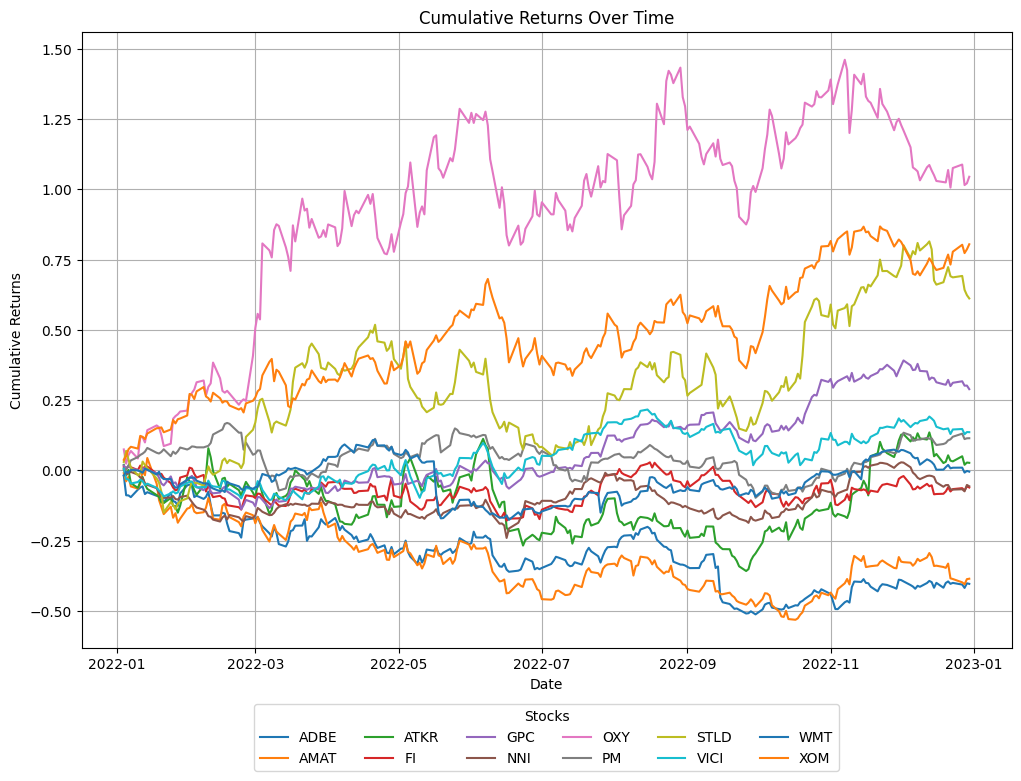

In [63]:
stock_df=dat_func.get_price_df(tickers,start_date,end_date)
returns_df=dat_func.get_log_returns(stock_df)
vis.plot_cumulative_returns(returns_df)

In [64]:
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10',start_date,start_date+pd.Timedelta(days=1))[0]/100

In [65]:
init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate)
init_weights=init_weights.round(3)
print('Initial Port Returns:',init_ret)
print('Initial Port Volatility:',init_std)
print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

Initial Port Returns: 0.4987088050039772
Initial Port Volatility: 0.2726123649603349
Initial Port Sharpe: 1.764809182716193
Optimal Weights: {'ADBE': 0.0, 'AMAT': 0.0, 'ATKR': 0.0, 'FI': 0.0, 'GPC': 0.259, 'NNI': 0.0, 'OXY': 0.039, 'PM': 0.0, 'STLD': 0.119, 'VICI': 0.0, 'WMT': 0.0, 'XOM': 0.583}


## Simulation:
### Geometric Brownian Motion: 

In [66]:
exp_ret=returns_df.mean()*252
exp_sig=returns_df.std()*np.sqrt(252)
exp_corr=returns_df.corr()
init_price=stock_df.iloc[0]
L = cholesky(exp_corr, lower=True)

def simulate_correlated_gbm(S0, mu, sigma, L, T, dt, paths):
    num_steps = int(T/dt)
    num_assets = len(mu)

    # Precompute drift and diffusion
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    # Initialize the prices array
    prices = np.zeros((num_steps + 1, num_assets, paths))
    prices[0, :, :] = S0[:, np.newaxis]
    
    # Generate increments for the Brownian motion
    for t in range(1, num_steps + 1):
        dW = np.dot(L, np.random.normal(size=(num_assets, paths)))
        prices[t, :, :] = prices[t-1, :, :] * np.exp(drift[:, np.newaxis] + diffusion[:, np.newaxis] * dW)
    
    return prices

# Parameters
T = 1.0  # time horizon (1 year)
dt = 1/252  # time step (daily)
paths = 1  # number of simulations

# Simulate
simulated_prices = simulate_correlated_gbm(init_price, exp_ret, exp_sig, L, T, dt, paths)

C:\Users\willl\AppData\Local\Temp\ipykernel_13892\1425336791.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  prices[0, :, :] = S0[:, np.newaxis]
C:\Users\willl\AppData\Local\Temp\ipykernel_13892\1425336791.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  prices[t, :, :] = prices[t-1, :, :] * np.exp(drift[:, np.newaxis] + diffusion[:, np.newaxis] * dW)


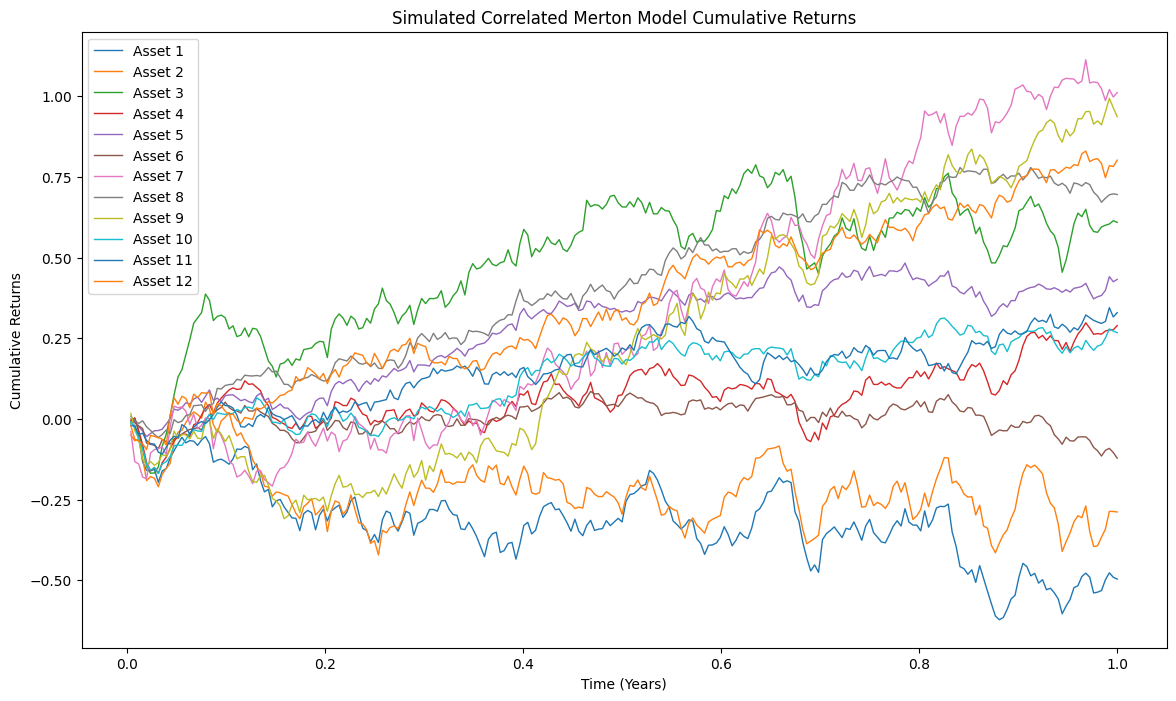

In [67]:
plt.figure(figsize=(14, 8))
time_steps = np.linspace(0, T, int(T/dt) + 1)

for i in range(simulated_prices.shape[1]):
    # Calculate returns: change axis to 0 because we need differences along time dimension
    returns = np.diff(simulated_prices[:, i, :1], axis=0) / simulated_prices[:-1, i, :10]
    cum_returns = np.cumsum(returns, axis=0)
    
    plt.plot(time_steps[1:], cum_returns, lw=1, label=f'Asset {i+1}')  # Skip the first time step as we have no return data for it

plt.title('Simulated Correlated Merton Model Cumulative Returns')
plt.xlabel('Time (Years)')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

### Merton Jump Diffusion: 

In [71]:
def simulate_merton(S0, mu, sigma, lambda_, m, v, L, T, dt, paths):
    num_steps = int(T/dt)
    num_assets = len(mu)
    drift = (mu - 0.5 * sigma**2 - lambda_ * (np.exp(m + 0.5 * v**2) - 1)) * dt
    diffusion = sigma * np.sqrt(dt)

    prices = np.zeros((num_steps + 1, num_assets, paths))
    prices[0, :, :] = S0[:, np.newaxis]
    
    for t in range(1, num_steps + 1):
        # Normal increments
        dW = np.dot(L, np.random.normal(size=(num_assets, paths)))
        # Jump components
        J = np.zeros((num_assets, paths))
        njumps = poisson.rvs(lambda_ * dt, size=(num_assets, paths))
        for i in range(num_assets):
            for j in range(paths):
                if njumps[i, j] > 0:
                    J[i, j] = np.sum(norm.rvs(loc=m, scale=v, size=njumps[i, j]))
        
        # Update prices
        prices[t, :, :] = prices[t-1, :, :] * np.exp(drift[:, np.newaxis] + diffusion[:, np.newaxis] * dW + J)
    
    return prices

# Simulation parameters
T = 1.0  # time horizon (1 year)
dt = 1/252  # time step (daily)
paths = 1  # number of simulations

lambda_ = 0.1  # Expected number of jumps per year
m = -0.2       # Expected relative jump size
v = 0.1        # Jump size volatility

# Simulate
simulated_prices = simulate_merton(init_price, exp_ret, exp_sig, lambda_, m, v, L, T, dt, paths)

C:\Users\willl\AppData\Local\Temp\ipykernel_13892\542552722.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  prices[0, :, :] = S0[:, np.newaxis]
C:\Users\willl\AppData\Local\Temp\ipykernel_13892\542552722.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  prices[t, :, :] = prices[t-1, :, :] * np.exp(drift[:, np.newaxis] + diffusion[:, np.newaxis] * dW + J)


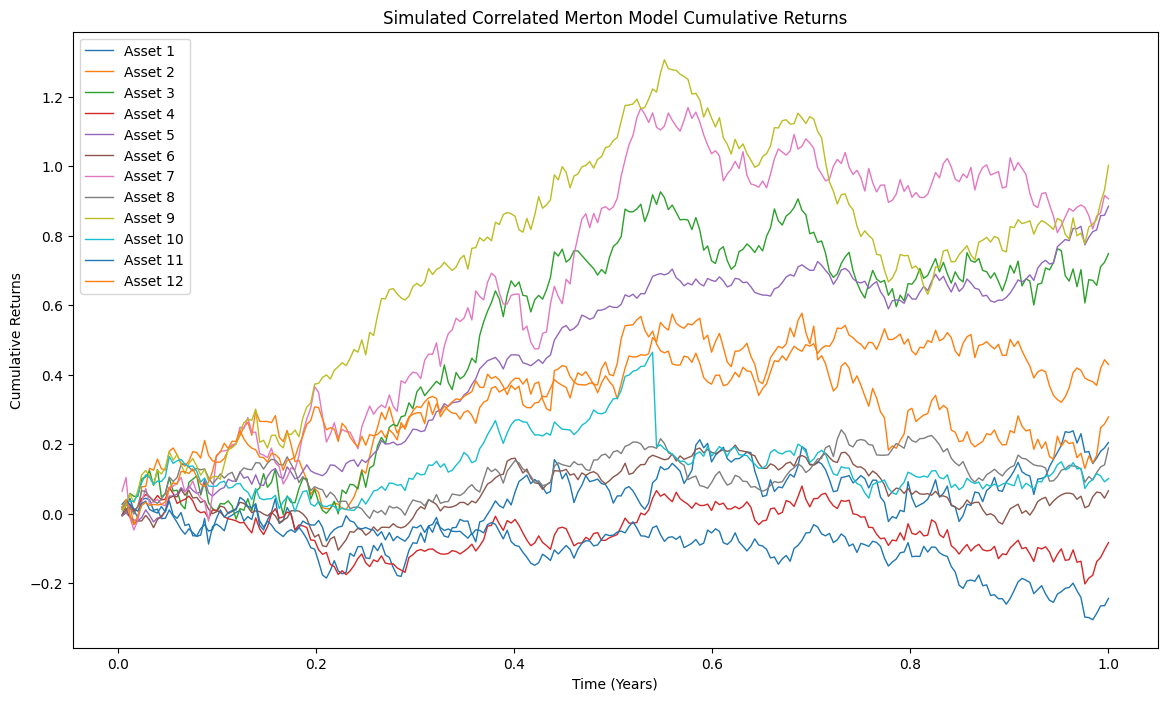

In [72]:
plt.figure(figsize=(14, 8))
time_steps = np.linspace(0, T, int(T/dt) + 1)

for i in range(simulated_prices.shape[1]):
    # Calculate returns: change axis to 0 because we need differences along time dimension
    returns = np.diff(simulated_prices[:, i, :1], axis=0) / simulated_prices[:-1, i, :10]
    cum_returns = np.cumsum(returns, axis=0)
    
    plt.plot(time_steps[1:], cum_returns, lw=1, label=f'Asset {i+1}')  # Skip the first time step as we have no return data for it

plt.title('Simulated Correlated Merton Model Cumulative Returns')
plt.xlabel('Time (Years)')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [1]:
import numpy as np
from scipy.linalg import cholesky, block_diag


class CEVMarket:
    def __init__(self, mu, alpha, sigma, correlation, start_state):
        self.mu = np.array(mu)  # Ensure mu is a numpy array
        self.alpha = np.array(alpha)  # Ensure alpha is a numpy array
        self.sigma = np.array(sigma)  # Ensure sigma is a numpy array
        self.start_state = np.array(start_state)  # Starting state of the market
        self.correlation = np.array(correlation)  # Correlation matrix
        self.L = cholesky(self.correlation, lower=True)  # Cholesky decomposition
        self.num_assets = len(mu)  # Number of assets

    def simulate(self, T, dt, num_paths):
        num_steps = int(T / dt)
        S = np.zeros((num_steps + 1, self.num_assets, num_paths))
        S[0, :, :] = self.start_state[:, np.newaxis]  # Initialize start state

        # Iterate over time steps
        for t in range(1, num_steps + 1):
            Z = np.random.normal(size=(self.num_assets, num_paths))
            dW = np.dot(self.L, Z)  # Apply Cholesky factor to get correlated Brownian increments

            # Extract the previous state
            S_prev = S[t - 1]

            # Compute the drift and diffusion terms
            drift = (self.mu[:, None] * dt - 
                     0.5 * (self.sigma[:, None] ** 2) * (S_prev ** (2 * self.alpha[:, None] - 2)) * dt)
            diffusion = self.sigma[:, None] * (S_prev ** (self.alpha[:, None] - 1)) * dW * np.sqrt(dt)

            # Update simulation ensuring proper broadcasting
            S[t] = S_prev * np.exp(drift + diffusion)

        return S


market = CEVMarket(exp_ret, np.array([1.4]*len(exp_ret)), exp_sig, exp_corr, init_price)
simulated_data = market.simulate(T=1, dt=1/252, num_paths=1)

plt.figure(figsize=(14, 8))
time_steps = np.linspace(0, T, int(T/dt) + 1)

for i in range(simulated_data.shape[1]):
    # Calculate returns: change axis to 0 because we need differences along time dimension
    returns = np.diff(simulated_data[:, i, :1], axis=0) / simulated_data[:-1, i, :10]
    cum_returns = np.cumsum(returns, axis=0)
    
    plt.plot(time_steps[1:], cum_returns, lw=1, label=f'Asset {i+1}')  # Skip the first time step as we have no return data for it

plt.title('Simulated Correlated CEV Model Cumulative Returns')
plt.xlabel('Time (Years)')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

NameError: name 'exp_ret' is not defined